# Example: Unicycle Robot solved by [Uniform grid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).

This example was adapted from the numerical experiments in [1, Sec. 5] from Symbolically guided Model Predictive Control (SgMPC)  [paper](https://doi.org/10.1016/j.ifacol.2022.09.039)..
This is a **control problem** for a **discrete-time nonlinear system**.

Let us consider the 3-dimensional state space control system of the form
$$
x_{t+1} = f(x_t, u_t)
$$
with $f: \mathbb{R}^3 × \mathbb{R}^2 \to \mathbb{R}^3$ given by
$$
f(x, (u_1, u_2)) = \begin{bmatrix} x_1 + u_1 \cos(x_3) \\ x_2 + u_1 \sin(x_3) \\ x_3 + u_2 \ (\text{mod} \ 2\pi) \end{bmatrix}
$$
and with state and control constraints given by:
$$
X = \left\{ (x_1, x_2)^T \in \mathbb{R}^2 \ | \ x_1^2 - x_2^2 \leq 4, \ 4x_2^2 - x_1^2 \leq 16 \right\}
$$
$$
U = [0.2, 2] \times [-1, 1]
$$
Here, $(x_1, x_2)$ represents the 2D Cartesian coordinates and $x_3$ is the angular orientation of a mobile cart.
The control inputs $u_1$ and $u_2$ are the linear and angular velocities.
The control objective is to drive the mobile cart to a desired reference position $x_r$.

Considering this as a reachability problem, we will use it to showcase the capabilities of the Uniform grid abstraction solving discrete-time problem in Dionysos.
The nonlinear constraints are handled as obstacles in the state-space.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos and JuMP.

In [2]:
using Dionysos, JuMP

Define the problem using JuMP
We first create a JuMP model:

In [3]:
model = Model(Dionysos.Optimizer)

A JuMP Model
├ solver: unknown
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Define the discretization step

In [4]:
hx = 0.1

0.1

Define the state variables: x1(t), x2(t), x3(t) without specifying the start value since here it's a set. We will specify the start later using constraints.

In [5]:
x_low = [-3.5, -2.6, -pi]
x_upp = -x_low
@variable(model, x_low[i] <= x[i = 1:3] <= x_upp[i])

3-element Vector{JuMP.VariableRef}:
 x[1]
 x[2]
 x[3]

Define the control variables: u1(t), u2(t)

In [6]:
@variable(model, -1 <= u[1:2] <= 1)

2-element Vector{JuMP.VariableRef}:
 u[1]
 u[2]

Define the dynamics, we do not include the remainder modulo `2π` for `Δ(x[3])`. There are options to set periodic variables in Dionysos but that's not needed for this example.

In [7]:
@constraint(model, Δ(x[1]) == x[1] + u[1] * cos(x[3]))
@constraint(model, Δ(x[2]) == x[2] + u[1] * sin(x[3]))
@constraint(model, Δ(x[3]) == x[3] + u[2])

Δ(x[3]) - (x[3] + u[2]) = 0

Define the initial and target sets

In [8]:
x_initial = [1.0, -1.7, 0.0]
x_target = [sqrt(32) / 3, sqrt(20) / 3, -pi]

@constraint(model, start(x[1]) in MOI.Interval(x_initial[1] - hx, x_initial[1] + hx))
@constraint(model, start(x[2]) in MOI.Interval(x_initial[2] - hx, x_initial[2] + hx))
@constraint(model, start(x[3]) in MOI.Interval(x_initial[3] - hx, x_initial[3] + hx))

@constraint(model, final(x[1]) in MOI.Interval(x_target[1] - hx, x_target[1] + hx))
@constraint(model, final(x[2]) in MOI.Interval(x_target[2] - hx, x_target[2] + hx))
@constraint(model, final(x[3]) in MOI.Interval{Float64}(-pi, pi))

final(x[3]) ∈ [-3.141592653589793, 3.141592653589793]

Obstacle boundaries computed using the function `get_obstacles` below

In [9]:
function extract_rectangles(matrix)
    if isempty(matrix)
        return []
    end

    n, m = size(matrix)
    tlx, tly, brx, bry = Int[], Int[], Int[], Int[]

    # Build histogram heights
    for i in 1:n
        j = 1
        while j <= m
            if matrix[i, j] == 1
                j += 1
                continue
            end
            push!(tlx, j)
            push!(tly, i)
            while j <= m && matrix[i, j] == 0
                j += 1
            end
            push!(brx, j - 1)
            push!(bry, i)
        end
    end

    return zip(tlx, tly, brx, bry)
end

function get_obstacles(lb, ub, h)
    # lb_x1 = -3.5, ub_x1 = 3.5, lb_x2 = -2.6, ub_x2 = 2.6, h = 0.1
    lb_x1, lb_x2, lb_x3 = lb
    ub_x1, ub_x2, ub_x3 = ub

    # Define the obstacles
    x1 = range(lb_x1; stop = ub_x1, step = h)
    x2 = range(lb_x2; stop = ub_x2, step = h)
    steps1, steps2 = length(x1), length(x2)

    X1 = x1' .* ones(steps2)
    X2 = ones(steps1)' .* x2

    Z1 = (X1 .^ 2 .- X2 .^ 2) .<= 4
    Z2 = (4 .* X2 .^ 2 .- X1 .^ 2) .<= 16

    # Find the upper and lower bounds of X1 and X2 for the obstacle
    grid = Z1 .& Z2

    return [
        MOI.HyperRectangle([x1[x1lb], x2[x2lb]], [x1[x1ub], x2[x2ub]]) for
        (x1lb, x2lb, x1ub, x2ub) in extract_rectangles(grid)
    ]
end

obstacles = get_obstacles(x_low, x_upp, hx)

114-element Vector{MathOptInterface.HyperRectangle{Float64}}:
 MathOptInterface.HyperRectangle{Float64}([-3.5, -2.6], [3.5, -2.6])
 MathOptInterface.HyperRectangle{Float64}([-3.5, -2.5], [-3.3, -2.5])
 MathOptInterface.HyperRectangle{Float64}([-2.9, -2.5], [2.9, -2.5])
 MathOptInterface.HyperRectangle{Float64}([3.3, -2.5], [3.5, -2.5])
 MathOptInterface.HyperRectangle{Float64}([-3.5, -2.4], [-3.2, -2.4])
 MathOptInterface.HyperRectangle{Float64}([-2.6, -2.4], [2.6, -2.4])
 MathOptInterface.HyperRectangle{Float64}([3.2, -2.4], [3.5, -2.4])
 MathOptInterface.HyperRectangle{Float64}([-3.5, -2.3], [-3.1, -2.3])
 MathOptInterface.HyperRectangle{Float64}([-2.2, -2.3], [2.2, -2.3])
 MathOptInterface.HyperRectangle{Float64}([3.1, -2.3], [3.5, -2.3])
 ⋮
 MathOptInterface.HyperRectangle{Float64}([-2.2, 2.3], [2.2, 2.3])
 MathOptInterface.HyperRectangle{Float64}([3.1, 2.3], [3.5, 2.3])
 MathOptInterface.HyperRectangle{Float64}([-3.5, 2.4], [-3.2, 2.4])
 MathOptInterface.HyperRectangle{Float64}([-

Function to add rectangular obstacle avoidance constraints

In [10]:
for obstacle in obstacles
    @constraint(model, x[1:2] ∉ obstacle)
end

### Definition of the abstraction

We define the growth bound function of $f$:

In [11]:
function growth_bound(r, u, _)
    β = u[1] * r[3]
    return StaticArrays.SVector{3}(β, β, 0.0)
end
set_attribute(model, "growthbound_map", growth_bound)

We define the inverse system map:

In [12]:
function sys_inv(x, u, _)
    return StaticArrays.SVector{3}(
        x[1] - u[1] * cos(x[3] - u[2]),
        x[2] - u[1] * sin(x[3] - u[2]),
        x[3] - u[2],
    )
end
set_attribute(model, "sys_inv_map", sys_inv)

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

In [13]:
x0 = SVector(0.0, 0.0, 0.0);
h = SVector(hx, hx, 0.2);
set_attribute(model, "state_grid", Dionysos.Domain.GridFree(x0, h))

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [14]:
u0 = SVector(1.1, 0.0);
h = SVector(0.3, 0.3);
set_attribute(model, "input_grid", Dionysos.Domain.GridFree(u0, h))

optimize!(model)

>>Setting up the model
>>Model setup complete
┌ Warning: Noise is not yet accounted for in system abstraction.
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/Nirnn/src/optim/abstraction/UniformGridAbstraction/empty_problem.jl:216
compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 5277352 transitions created
┌ Warning: The `state_cost` and `transition_cost` are not yet fully implemented
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/Nirnn/src/optim/abstraction/UniformGridAbstraction/optimal_control_problem.jl:94

 Reachability: terminated with success


Get the results

In [15]:
abstract_system = get_attribute(model, "abstract_system");
abstract_problem = get_attribute(model, "abstract_problem");
abstract_controller = get_attribute(model, "abstract_controller");
concrete_controller = get_attribute(model, "concrete_controller")
concrete_problem = get_attribute(model, "concrete_problem");
concrete_system = concrete_problem.system

MathematicalSystems.ConstrainedBlackBoxControlDiscreteSystem{Dionysos.var"#10#11"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xd6b625b6, 0x6660be4f, 0xcaca2fd2, 0xa0d4612d, 0x83257eb2), Expr}}, Dionysos.Utils.LazySetMinus{Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{3, Float64}}, Dionysos.Utils.LazyUnionSetArray{Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{3, Float64}}}}, Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Float64}}}(Dionysos.var"#10#11"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xd6b625b6, 0x6660be4f, 0xcaca2fd2, 0xa0d4612d, 0x83257eb2), Expr}}(RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xd6b625b6, 0x6660be4f, 0xcaca2fd2, 0xa0d4612d, 0x83257eb2), Expr}(:(#= /home/runner/.julia/packages

### Trajectory display
We choose a stopping criterion `reached` and the maximal number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space `_I_` defined previously.

In [16]:
nstep = 100
function reached(x)
    if x ∈ concrete_problem.target_set
        return true
    else
        return false
    end
end

control_trajectory = Dionysos.System.get_closed_loop_trajectory(
    get_attribute(model, "discretized_system"),
    concrete_controller,
    x_initial,
    nstep;
    stopping = reached,
)

using Plots

Here we display the coordinate projection on the two first components of the state space along the trajectory.

In [17]:
fig = plot(; aspect_ratio = :equal);

We display the concrete domain

In [18]:
plot!(concrete_system.X; color = :yellow, opacity = 0.5);

We display the abstract domain

In [19]:
plot!(abstract_system.Xdom; color = :blue, opacity = 0.5);

We display the concrete specifications

In [20]:
plot!(concrete_problem.initial_set; color = :green, opacity = 0.2);
plot!(concrete_problem.target_set; dims = [1, 2], color = :red, opacity = 0.2);

We display the abstract specifications

In [21]:
plot!(
    Dionysos.Symbolic.get_domain_from_symbols(
        abstract_system,
        abstract_problem.initial_set,
    );
    color = :green,
);
plot!(
    Dionysos.Symbolic.get_domain_from_symbols(abstract_system, abstract_problem.target_set);
    color = :red,
);

We display the concrete trajectory

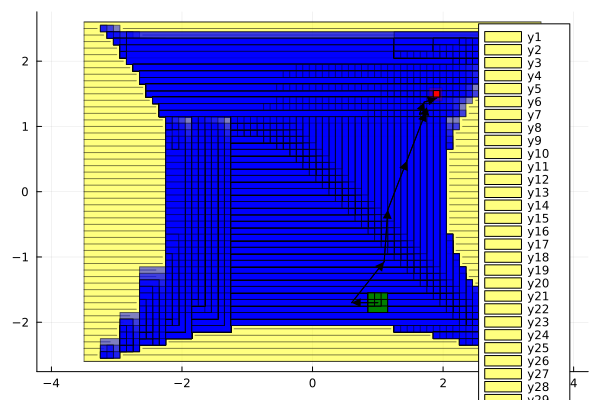

In [22]:
plot!(control_trajectory; ms = 0.5)

### References
1. Z. Azaki, A. Girard and S. Olaru, "Predictive and Symbolic Control: Performance and Safety for Non-linear Systems," in IFAC-PapersOnLine, 2022, vol. 55, no 16, pp. 290-295..

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*